# IMA205 Challenge

Louis Martinez

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os

## Loading data

In [183]:
def load_mris(dir):
    """Utility function to load all mris from test and train directories."""
    mris = []
    for sample in os.listdir(dir):
        mri_dir = os.path.join(dir, sample)
        sample_mris = []
        for mri in os.listdir(mri_dir):
            # Load mri
            mri_data = nib.load(os.path.join(mri_dir, mri)).get_fdata()
            sample_mris.append(mri_data)

        mris.append(sample_mris)

    return np.array(mris, dtype=object)


def plot_slices(slices, title=None, rows=2, cols=5):
    """Function to plot slices of a MRI"""
    n_slices=slices.shape[0]
    fig, axes = plt.subplots(n_slices//5 if n_slices%5==0 else n_slices//5+1, n_slices if n_slices < 5 else 5, figsize=(20, 7*(n_slices//5-1) if n_slices > 5 else 4))
    ax=axes.ravel()
    for i, slice in enumerate(slices):
        ax[i].pcolormesh(slice)
        ax[i].set_title(f'Slice {i}')
    if title:
        fig.suptitle(title, fontsize=20)
    plt.show()

In [3]:
# LOAD CSV FILES

train_csv='metaDataTrain.csv'
test_csv='metaDataTest.csv'

df_train=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)

X_train=df_train[['Height','Weight']].to_numpy()
y_train=df_train[['Category']].to_numpy().ravel()
X_test=df_test[['Height','Weight']].to_numpy()

X_cat = [X_train[y_train == i] for i in range(y_train.max() + 1)] # split by category


In [172]:
# LOAD MRI DATA
train_dir = 'Train'
test_dir = 'Test'

mri_train = load_mris(train_dir)
mri_test = load_mris(test_dir)

In [173]:
n_train_samples, n_train_mri = mri_train.shape
n_test_samples, n_test_mri = mri_test.shape

# Format MRI and segmentation masks as (num_slices, height, width)
for i in range(n_train_samples):
    for j in range(n_train_mri):
        mri_train[i][j] = np.transpose(mri_train[i][j], (2, 0, 1))

for i in range(n_test_samples):
    for j in range(n_test_mri):
        mri_test[i][j] = np.transpose(mri_test[i][j], (2, 0, 1))

print(f'Train MRI shape: {mri_train.shape}')
print(f'Test MRI shape: {mri_test.shape}')
print(f'MRI shape : {mri_train[0][0].shape}')

Train MRI shape: (100, 4)
Test MRI shape: (50, 4)
MRI shape : (10, 216, 256)


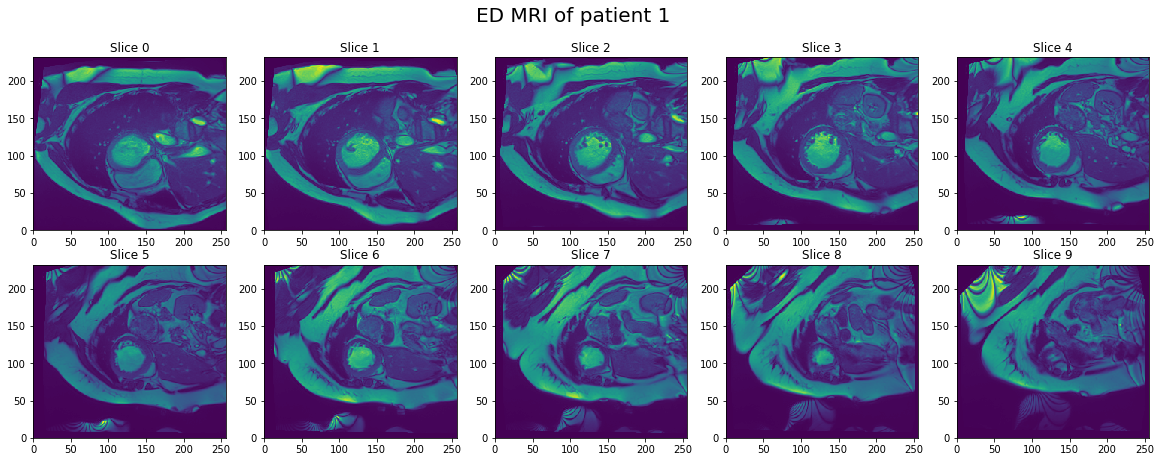

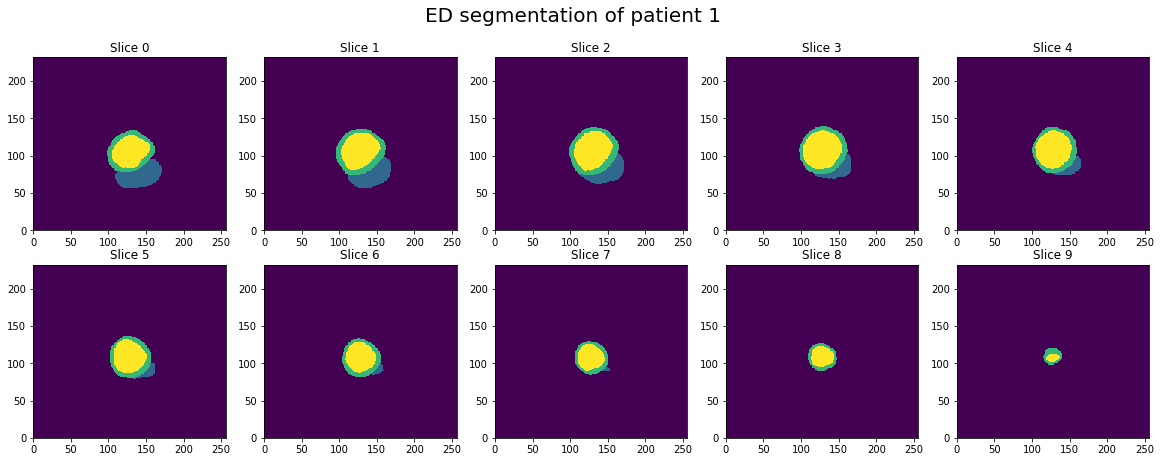

In [184]:
patient_idx=1
ed_mri_idx=0
ed_mask_idx=1

plot_slices(mri_train[patient_idx][ed_mri_idx], title=f'ED MRI of patient {patient_idx}')
plot_slices(mri_train[patient_idx][ed_mask_idx], title=f'ED segmentation of patient {patient_idx}')

## Segmentation of the Left ventricle

I decided to apply the method described in the book [Information Technologies in Biomedicine](https://link.springer.com/chapter/10.1007/978-3-642-31196-3_3#chapter-info)

Let's first apply a low-pass filter on mri

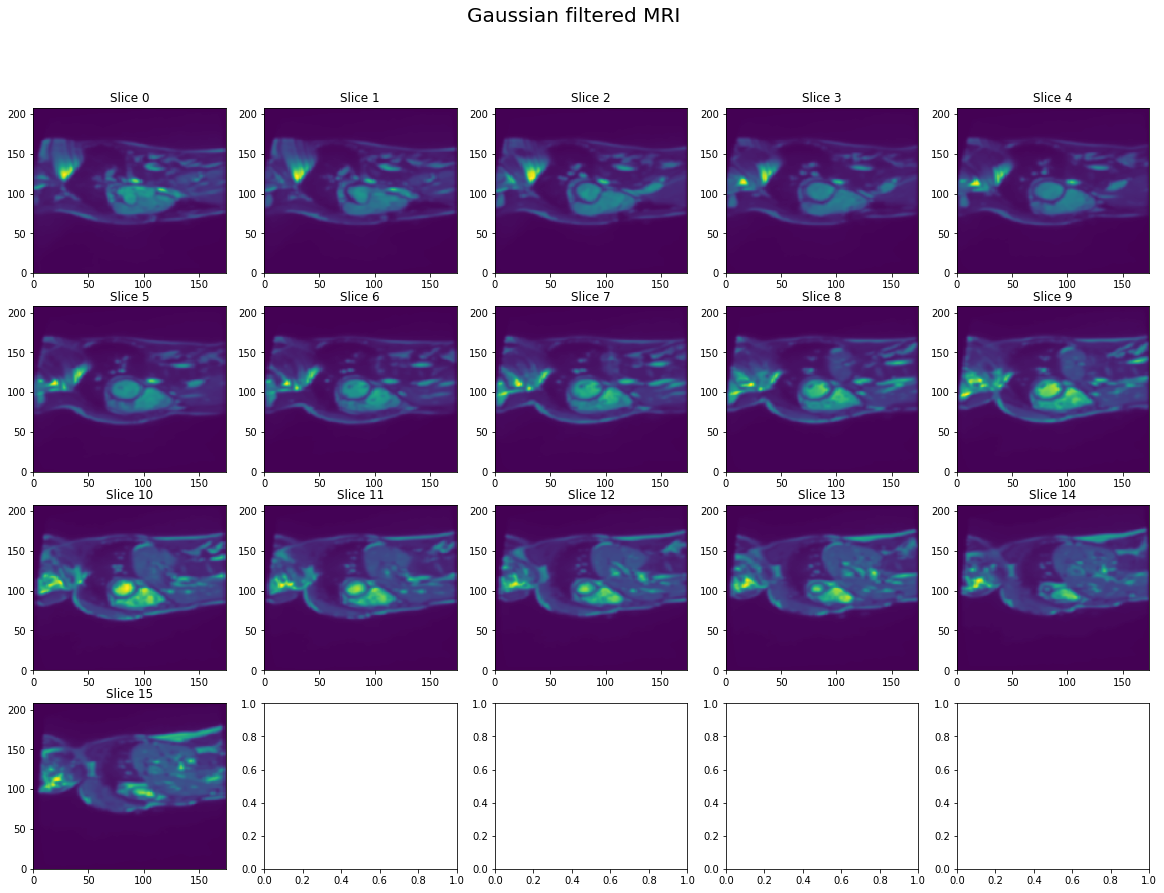

In [216]:
from skimage.filters import gaussian

mri=mri_test[patient_idx][ed_mri_idx]

sigma_gauss=1.5
size_gauss=7 #49 coefficients
gauss_filter=lambda x: gaussian(x, sigma=sigma_gauss, truncate=size_gauss/2)

mri_gauss=np.vectorize(gauss_filter, signature='(n,m)->(n,m)')(mri)
# plot_slices(slices=mri_gauss, title='Gaussian filtered MRI')
plot_slices(slices=mri_gauss, title='Gaussian filtered MRI')

Then we use an edge detector by applying a Canny filter. (as recommended by the article)

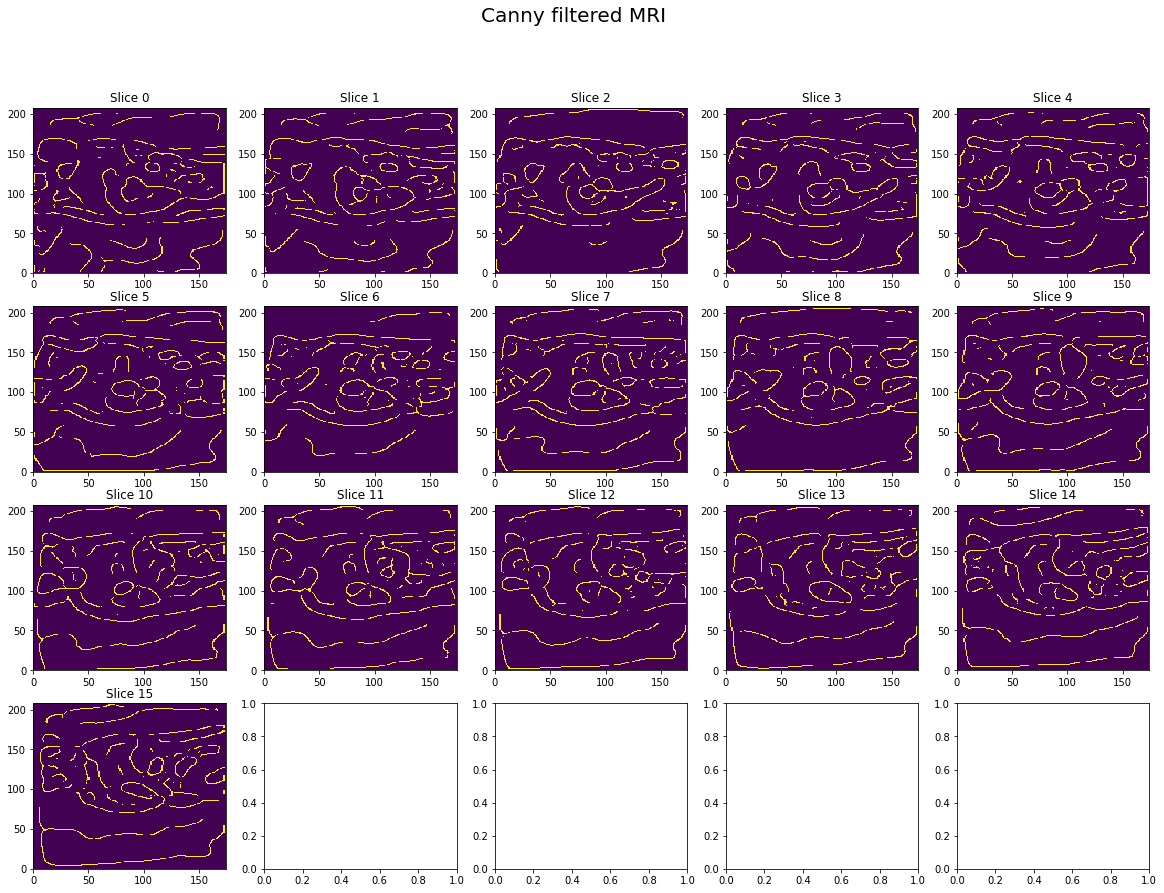

In [218]:
from skimage.feature import canny

sigma_canny=5
canny_filter=lambda x: canny(x, sigma=sigma_canny)

mri_canny=np.vectorize(canny_filter, signature='(n,m)->(n,m)')(mri_gauss)
plot_slices(mri_canny, title='Canny filtered MRI')

Newt we compute Gradient Vector Flow Forces using GVF algorithm

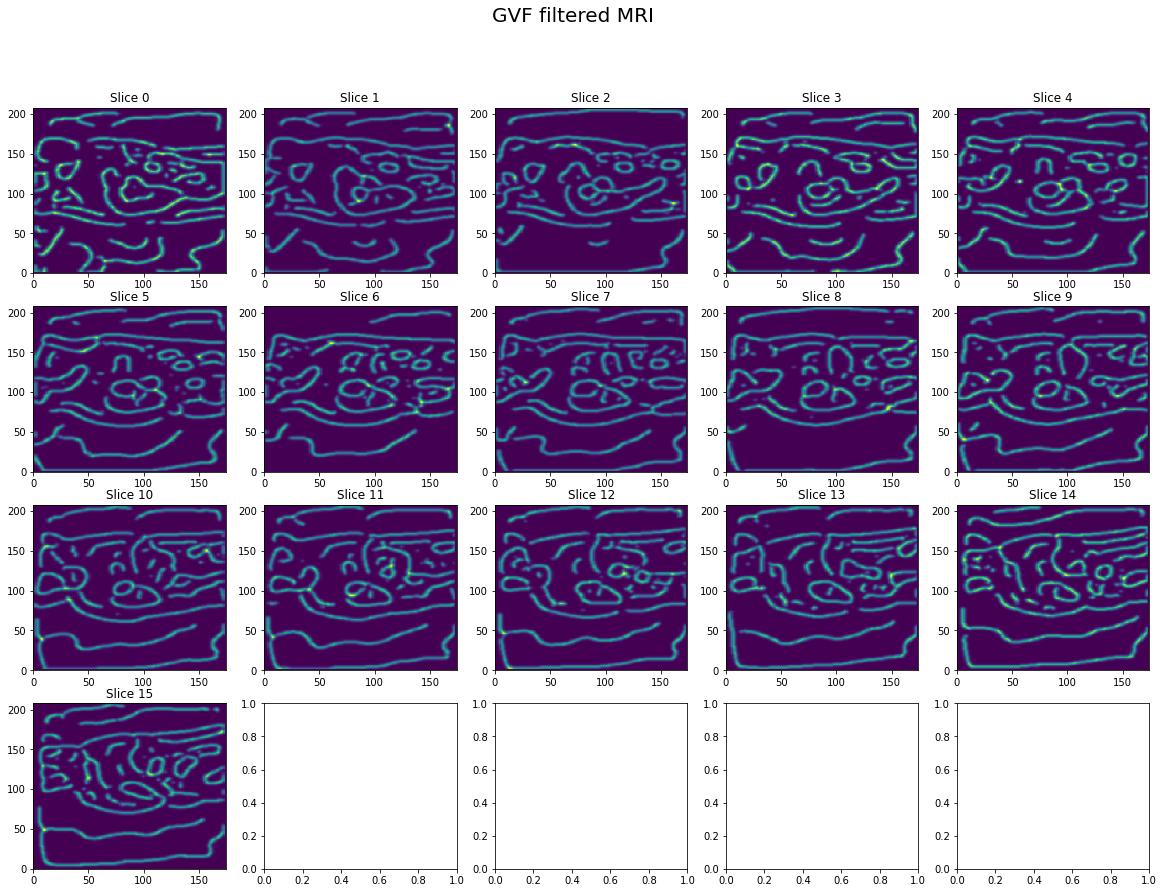

In [219]:
from skimage.filters import sobel_h, sobel_v, laplace

def GVF(edgemap, mu=0.02, iterations=100):
    """Gradient Vector Flow algorithm for edge detection"""
    # Initialize
    u = np.zeros(edgemap.shape)
    v = np.zeros(edgemap.shape)
    u[1:-1, 1:-1] = edgemap[1:-1, 1:-1]
    v[1:-1, 1:-1] = edgemap[1:-1, 1:-1]

    for i in range(iterations):
        # We use laplacian
        u[1:-1, 1:-1] = (u[1:-1, 1:-1] + mu * (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1])) / (1 + 4 * mu)
        v[1:-1, 1:-1] = (v[1:-1, 1:-1] + mu * (v[2:, 1:-1] + v[:-2, 1:-1] + v[1:-1, 2:] + v[1:-1, :-2] - 4 * v[1:-1, 1:-1])) / (1 + 4 * mu)

    return u, v

def GVF_filter(edgemap, mu=0.02, iterations=50):
    """Filter an edge map using GVF"""
    u, v = GVF(edgemap, mu=mu, iterations=iterations)
    return np.sqrt(u**2 + v**2)

mri_gvf=np.vectorize(GVF_filter, signature='(n,m)->(n,m)')(mri_canny)
plot_slices(mri_gvf, title='GVF filtered MRI')


We finally use active contour to segment the ventricle

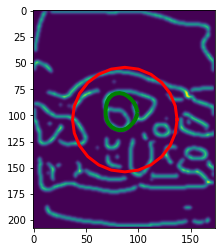

In [220]:
from skimage.segmentation import active_contour

slc=mri_gvf[8].copy()
slc=(slc-slc.min())/(slc.max()-slc.min())

c_x,c_y=slc.shape[0]//2, slc.shape[1]//2
r0=50
s=np.linspace(0,2*np.pi,25)
r=c_x+r0*np.sin(s)
c=c_y+r0*np.cos(s)
init=np.array([r,c]).T
n_iter=100

snake=active_contour(slc, init, alpha=0.01, beta=0.5, gamma=0.5, convergence=1e-5)

plt.imshow(slc)
plt.plot(init[:,1], init[:,0], '-r', lw=3)
plt.plot(snake[:,1], snake[:,0], '-g', lw=4)
plt.show()

---

In [221]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn 


We plot height and weight for each category 

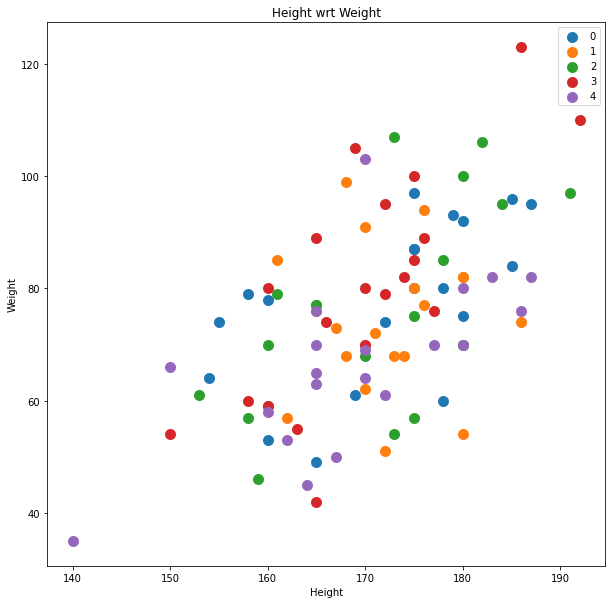

In [5]:
plt.figure(figsize=(10,10))
for i in range(len(X_cat)):
    plt.scatter(X_cat[i][:,0], X_cat[i][:,1], label=str(i), linewidths=5)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height wrt Weight')
plt.legend()
plt.show()

There seem to be no easy way to separate data into distinct categories only according to there distribution.<br>
It justifies the fact that we need to extract features from heart MRIs to seperate categories.

## Features extraction